Downloading spacy tokenizers for German, English and French

In [ ]:
!python -m spacy download de
!python -m spacy download en
!python -m spacy download fr

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


Importing necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.utils import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import collections
import spacy
import numpy as np

import random
import math
import time

In [ ]:
# Set the random seed for reproducability
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Creating tokenizer instances

In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')
spacy_fr = spacy.load('fr')

In [ ]:
def tokenize_de(text):

    # Tokenizes German text from a string into a list of strings

    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):

    # Tokenizes English text from a string into a list of strings

    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):

    # Tokenizes French text from a string into a list of strings

    return [tok.text for tok in spacy_fr.tokenizer(text)]

Defining source language and target language fields

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Splitting dataset into train, validation and test data

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

Defining the Encoder, Attention Module, Decoder and the overarching Model class

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

Creating the base Seq2Seq model

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

seq2seq = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)


In [ ]:
# Initializing the model parameters
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
seq2seq.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 20,518,917 trainable parameters


In [ ]:
optimizer = optim.Adam(seq2seq.parameters())

TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Defining the Train and Evaluate methods

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
# Function to calculate Epoch Time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training the model

In [ ]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(seq2seq, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(seq2seq, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'base-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 35s
	Train Loss: 5.045 | Train PPL: 155.267
	 Val. Loss: 4.786 |  Val. PPL: 119.841
Epoch: 02 | Time: 1m 35s
	Train Loss: 4.130 | Train PPL:  62.203
	 Val. Loss: 4.197 |  Val. PPL:  66.508
Epoch: 03 | Time: 1m 35s
	Train Loss: 3.381 | Train PPL:  29.408
	 Val. Loss: 3.593 |  Val. PPL:  36.357
Epoch: 04 | Time: 1m 35s
	Train Loss: 2.875 | Train PPL:  17.733
	 Val. Loss: 3.382 |  Val. PPL:  29.441
Epoch: 05 | Time: 1m 34s
	Train Loss: 2.490 | Train PPL:  12.061
	 Val. Loss: 3.256 |  Val. PPL:  25.944
Epoch: 06 | Time: 1m 35s
	Train Loss: 2.206 | Train PPL:   9.082
	 Val. Loss: 3.280 |  Val. PPL:  26.588
Epoch: 07 | Time: 1m 34s
	Train Loss: 1.960 | Train PPL:   7.096
	 Val. Loss: 3.167 |  Val. PPL:  23.746
Epoch: 08 | Time: 1m 35s
	Train Loss: 1.769 | Train PPL:   5.863
	 Val. Loss: 3.257 |  Val. PPL:  25.961
Epoch: 09 | Time: 1m 35s
	Train Loss: 1.614 | Train PPL:   5.021
	 Val. Loss: 3.273 |  Val. PPL:  26.400
Epoch: 10 | Time: 1m 35s
	Train Loss: 1.502 | Train PPL

Creating a new model from the base model, by taking its decdoder and freezing its layers.

In [ ]:
for name, child in seq2seq.named_children():
    print(name)

trained_encoder = list(seq2seq.children())[0]
trained_decoder = list(seq2seq.children())[1] 

encoder
decoder


In [ ]:
# Freezing the decoder layers
for param in trained_decoder.parameters():    
    param.requires_grad = False

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = trained_decoder

new_model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

Training new model with the frozen decoder

In [ ]:
print(f'The model has {count_parameters(new_model):,} trainable parameters')

N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(new_model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(new_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(new_model.state_dict(), 'new-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

The model has 4,901,120 trainable parameters
Epoch: 01 | Time: 1m 12s
	Train Loss: 9.562 | Train PPL: 14217.408
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 02 | Time: 1m 11s
	Train Loss: 9.542 | Train PPL: 13933.589
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 03 | Time: 1m 11s
	Train Loss: 9.621 | Train PPL: 15077.078
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 04 | Time: 1m 11s
	Train Loss: 9.617 | Train PPL: 15022.144
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 05 | Time: 1m 12s
	Train Loss: 9.614 | Train PPL: 14967.571
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 06 | Time: 1m 12s
	Train Loss: 9.571 | Train PPL: 14344.367
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 07 | Time: 1m 12s
	Train Loss: 9.558 | Train PPL: 14156.732
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 08 | Time: 1m 12s
	Train Loss: 9.553 | Train PPL: 14084.440
	 Val. Loss: 11.192 |  Val. PPL: 72522.477
Epoch: 09 | Time: 1m 12s
	Train Loss: 9.567 | Train PPL: 14281.219
	 Val. L

Unfreezing the decoder and training some more

In [ ]:
for param in new_model.parameters():    
    param.requires_grad = True

print(f'The model has {count_parameters(new_model):,} trainable parameters')

N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(new_model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(new_model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(new_model.state_dict(), 'new-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

The model has 20,518,917 trainable parameters
Epoch: 01 | Time: 1m 35s
	Train Loss: 3.937 | Train PPL:  51.274
	 Val. Loss: 3.898 |  Val. PPL:  49.303
Epoch: 02 | Time: 1m 36s
	Train Loss: 3.024 | Train PPL:  20.584
	 Val. Loss: 3.650 |  Val. PPL:  38.490
Epoch: 03 | Time: 1m 35s
	Train Loss: 2.770 | Train PPL:  15.966
	 Val. Loss: 3.599 |  Val. PPL:  36.564
Epoch: 04 | Time: 1m 35s
	Train Loss: 2.623 | Train PPL:  13.776
	 Val. Loss: 3.533 |  Val. PPL:  34.239
Epoch: 05 | Time: 1m 35s
	Train Loss: 2.464 | Train PPL:  11.752
	 Val. Loss: 3.551 |  Val. PPL:  34.863
Epoch: 06 | Time: 1m 35s
	Train Loss: 2.389 | Train PPL:  10.904
	 Val. Loss: 3.528 |  Val. PPL:  34.062
Epoch: 07 | Time: 1m 35s
	Train Loss: 2.314 | Train PPL:  10.117
	 Val. Loss: 3.496 |  Val. PPL:  32.970
Epoch: 08 | Time: 1m 35s
	Train Loss: 2.216 | Train PPL:   9.172
	 Val. Loss: 3.537 |  Val. PPL:  34.373
Epoch: 09 | Time: 1m 36s
	Train Loss: 2.192 | Train PPL:   8.957
	 Val. Loss: 3.520 |  Val. PPL:  33.789
Epoch: 10

Defining methods to translate sentences and plot attention

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Testing the model for translation

In [ ]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

predicted trg = ['the', 'blue', 'with', 'blue', 'blue', 'open', 'blue', 'each', 'each', 'each', 'each', 'other', '<eos>']


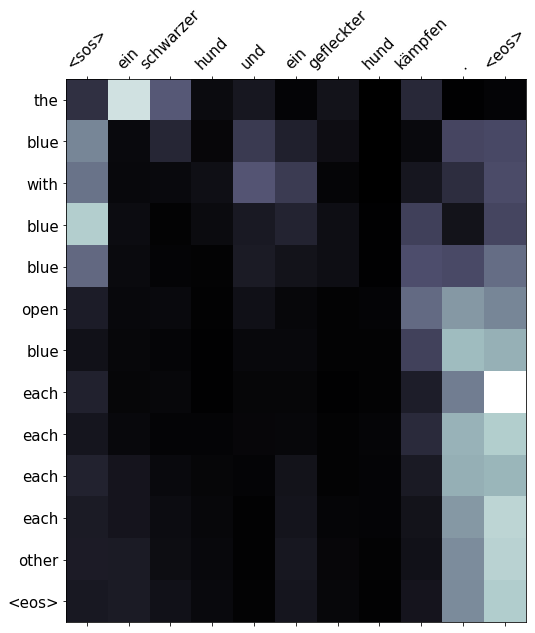

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'fighting', '.', '<eos>']


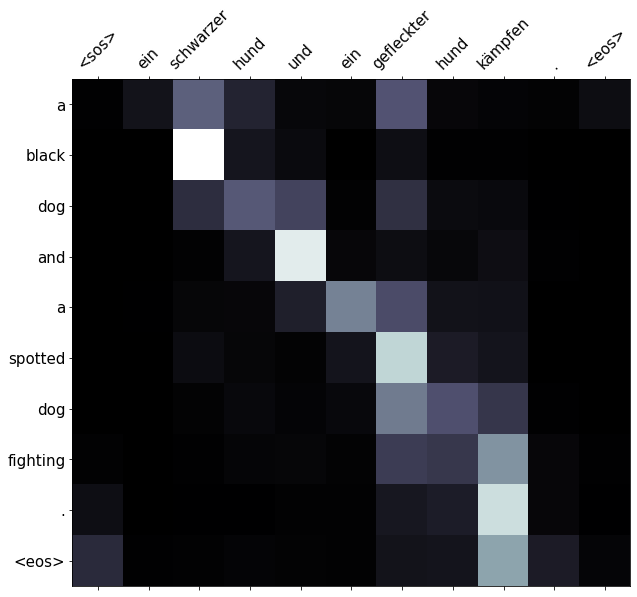

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, seq2seq, device)

print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

translation, attention = translate_sentence(src, SRC, TRG, new_model, device)

print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

Calculating the bleu scores and comparing them

In [ ]:
# Calculating score for base model

avg_score = 0
j = 0

for x in test_data:
  src = vars(test_data.examples[j])['src']
  trg = vars(test_data.examples[j])['trg']
  translation, attention = translate_sentence(src, SRC, TRG, seq2seq, device)
  score = sentence_bleu(translation, trg, weights=(1, 0, 0, 0))
  avg_score = avg_score + score
  j = j + 1

print("-----------------------------------------------------------------------------------------------")
avg_score = avg_score/len(test_data)
print(f'BLEU score for base seq2seq model = {avg_score*100:.2f}')


# Calculating score for new model

avg_score = 0
j = 0

for x in test_data:
  src = vars(test_data.examples[j])['src']
  trg = vars(test_data.examples[j])['trg']
  translation, attention = translate_sentence(src, SRC, TRG, new_model, device)
  score = sentence_bleu(translation, trg, weights=(1, 0, 0, 0))
  avg_score = avg_score + score
  j = j + 1

print("-----------------------------------------------------------------------------------------------")
avg_score = avg_score/len(test_data)
print(f'BLEU score for finetuned seq2seq model = {avg_score*100:.2f}')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


-----------------------------------------------------------------------------------------------
BLEU score for base seq2seq model = 13.53
-----------------------------------------------------------------------------------------------
BLEU score for finetuned seq2seq model = 15.46
